In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pylab as plt
from skimage import io
from skimage import img_as_uint
from stretchablecorr import *

from skimage.data import rocket

(427, 640, 3)
(150, 322)


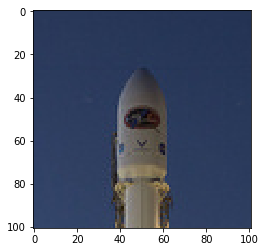

In [3]:
# ======
#  Crop
# ======
x, y = (322, 150)
plt.imshow(rocket());
print(rocket().shape)
plt.plot(x, y, 'sr');
C, ij = crop(rocket(), (x, y), 50)
plt.imshow(C);
print(ij)

In [4]:
C, ij = crop(rocket(), (322.2, 150.8), 50)
print(ij)

(151, 322)


In [5]:
# ============
#  get shifts
# ============

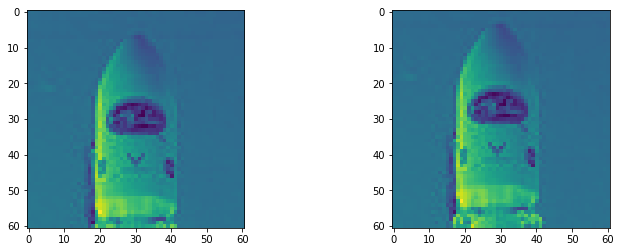

In [6]:
I = rocket().mean(axis=2)

window_half_size = 30
A, ij = crop(I, (322, 150), window_half_size)
B, ij = crop(I, (323, 153), window_half_size)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
ax1.imshow(A);
ax2.imshow(B);
# shifts  = -1, -3

In [7]:
get_shifts(A, B, window_half_size, window_half_size,
           window_half_size=15,
           offset=(0.0, 0.0),
           coarse_search=False,
           upsample_factor=100,
           method='skimage')

(-1.01, -2.93, 0.11381233475481252)

In [8]:
get_shifts(A, B, window_half_size, window_half_size,
           window_half_size=10,
           offset=(0.0, 0.0),
           coarse_search=True,
           upsample_factor=100,
           method='skimage')

(-1.0, -3.0, 1.8250120749944284e-08)

In [9]:
get_shifts(A, B, window_half_size, window_half_size,
           window_half_size=10,
           coarse_search=True,
           method='opti')

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
Failed in nopython mode pipeline (step: nopython frontend)
Invalid use of Function(<built-in function arange>) with argument(s) of type(s): (Literal[int](0), int64, dtype=class(int64))
 * parameterized
In definition 0:
    AssertionError: 
    raised from /home/etiennenavarro/notebooks/py3/lib/python3.6/site-packages/numba/typing/npydecl.py:631
In definition 1:
    AssertionError: 
    raised from /home/etiennenavarro/notebooks/py3/lib/python3.6/site-packages/numba/typing/npydecl.py:631
This error is usually caused by passing an argument of a type that is unsupported by the named function.
[1] During: resolving callee type: Function(<built-in function arange>)
[2] During: typing of call at /home/etiennenavarro/notebooks/stretchablecorr/opti_registration.py (21)


File "opti_registration.py", line 21:
def custom_fftfreq(n):
    <source elided>
    N = (n-1)//2 + 1
    p1 = np.arange(0, N, dtype=np.int64)
    ^

[1] During: resolving callee type: type(CPUDispatcher(<function custom_fftfreq at 0x7fd867279950>))
[2] During: typing of call at /home/etiennenavarro/notebooks/stretchablecorr/opti_registration.py (31)

[3] During: resolving callee type: type(CPUDispatcher(<function custom_fftfreq at 0x7fd867279950>))
[4] During: typing of call at /home/etiennenavarro/notebooks/stretchablecorr/opti_registration.py (32)

[5] During: resolving callee type: type(CPUDispatcher(<function custom_fftfreq at 0x7fd867279950>))
[6] During: typing of call at /home/etiennenavarro/notebooks/stretchablecorr/opti_registration.py (31)


File "opti_registration.py", line 31:
def dft_dot(A, yx):
    <source elided>
    y, x = yx
    yky = np.exp( im2pi * y * custom_fftfreq(A.shape[0]) )
    ^

This is not usually a problem with Numba itself but instead often caused by
the use of unsupported features or an issue in resolving types.

To see Python/NumPy features supported by the latest release of Numba visit:
http://numba.pydata.org/numba-doc/latest/reference/pysupported.html
and
http://numba.pydata.org/numba-doc/latest/reference/numpysupported.html

For more information about typing errors and how to debug them visit:
http://numba.pydata.org/numba-doc/latest/user/troubleshoot.html#my-code-doesn-t-compile

If you think your code should work with Numba, please report the error message
and traceback, along with a minimal reproducer at:
https://github.com/numba/numba/issues/new


In [10]:
%%timeit
get_shifts(A, B, window_half_size, window_half_size,
           window_half_size=10,
           coarse_search=True,
           method='opti')

# 2.1 ms ± 18.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
# 1.88 ms ± 8.03 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)

1.9 ms ± 58.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [12]:
%%timeit
get_shifts(A, B, window_half_size, window_half_size,
           window_half_size=10,
           coarse_search=False,
           method='opti')

# 3.09 ms ± 35.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
# 1.25 ms ± 22 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
# 766 µs ± 140 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)  with jit

729 µs ± 4.66 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [11]:
%%timeit
get_shifts(A, B, window_half_size, window_half_size,
           window_half_size=10,
           upsample_factor=100,
           coarse_search=True,
           method='skimage')

6.29 ms ± 302 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [13]:
%%timeit
get_shifts(A, B, window_half_size, window_half_size,
           window_half_size=10,
           upsample_factor=100,
           coarse_search=False,
           method='skimage')

3.12 ms ± 261 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
